# TF Hub for TF2: Text classification for behavior channel


This notebook classifies movie reviews as *positive* or *negative* using the text of the review. This is an example of *binary*—or two-class—classification, an important and widely applicable kind of machine learning problem. 

We'll use the [IMDB dataset](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/imdb) that contains the text of 50,000 movie reviews from the [Internet Movie Database](https://www.imdb.com/). These are split into 25,000 reviews for training and 25,000 reviews for testing. The training and testing sets are *balanced*, meaning they contain an equal number of positive and negative reviews. 

This notebook uses [tf.keras](https://www.tensorflow.org/guide/keras), a high-level API to build and train models in TensorFlow, and [TensorFlow Hub](https://www.tensorflow.org/hub), a library and platform for transfer learning. For a more advanced text classification tutorial using `tf.keras`, see the [MLCC Text Classification Guide](https://developers.google.com/machine-learning/guides/text-classification/).

In [10]:
from __future__ import absolute_import, division, print_function

import numpy as np

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

Version:  2.1.0
Eager mode:  True
Hub version:  0.7.0
GPU is NOT AVAILABLE


In [3]:
import pandas as pd

behaviour_view_file = '../data/transcripts_behaviour_channel.txt.gz'
behaviour_view_df = pd.read_csv(behaviour_view_file, usecols=['Label', 'Text'], sep='|')
# behaviour_view_df.head(2)
len(behaviour_view_df)


571

In [7]:
type(behaviour_view_df['Text'].values)

numpy.ndarray

In [32]:
sentences = behaviour_view_df['Text'].values
y = behaviour_view_df['Label'].values

train_examples, test_examples, train_labels, test_labels = train_test_split(sentences, y, test_size=0.25, random_state=1000)

In [25]:
print("Training entries: {}, test entries: {}".format(len(train_examples), len(test_examples)))

Training entries: 428, test entries: 143


In [34]:
type(train_examples)

numpy.ndarray

In [16]:
train_data, test_data = tfds.load(name="imdb_reviews", split=["train", "test"], batch_size=-1, as_supervised=True)

train_examples, train_labels = tfds.as_numpy(train_data)
test_examples, test_labels = tfds.as_numpy(test_data)

Let's also print the first 10 labels.

In [33]:
train_labels[:10]

array([0, 1, 0, 1, 0, 0, 0, 1, 0, 0])

## Build the model

The neural network is created by stacking layers—this requires three main architectural decisions:

* How to represent the text?
* How many layers to use in the model?
* How many *hidden units* to use for each layer?

In this example, the input data consists of sentences. The labels to predict are either 0 or 1.

One way to represent the text is to convert sentences into embeddings vectors. We can use a pre-trained text embedding as the first layer, which will have two advantages:
*   we don't have to worry anout text preprocessing,
*   we can benefit from transfer learning.

For this example we will use a model from [TensorFlow Hub](https://www.tensorflow.org/hub) called [google/tf2-preview/gnews-swivel-20dim/1](https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1).

There are three other models to test for the sake of this tutorial:
* [google/tf2-preview/gnews-swivel-20dim-with-oov/1](https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim-with-oov/1) - same as [google/tf2-preview/gnews-swivel-20dim/1](https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1), but with 2.5% vocabulary converted to OOV buckets. This can help if vocabulary of the task and vocabulary of the model don't fully overlap.
* [google/tf2-preview/nnlm-en-dim50/1](https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1) - A much larger model with ~1M vocabulary size and 50 dimensions.
* [google/tf2-preview/nnlm-en-dim128/1](https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1) - Even larger model with ~1M vocabulary size and 128 dimensions.

Let's first create a Keras layer that uses a TensorFlow Hub model to embed the sentences, and try it out on a couple of input examples. Note that the output shape of the produced embeddings is a expected: `(num_examples, embedding_dimension)`.

In [35]:
model = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1"
hub_layer = hub.KerasLayer(model, output_shape=[20], input_shape=[], dtype=tf.string, trainable=True)
hub_layer(train_examples[:3])

<tf.Tensor: shape=(3, 20), dtype=float32, numpy=
array([[  5.177446  , -23.872145  ,  13.413322  ,  14.54031   ,
        -27.13542   , -32.574497  , -14.098836  ,   9.230665  ,
          7.495556  ,   5.187854  , -14.628453  ,  10.79578   ,
          3.7991147 ,   5.9284825 , -27.54009   ,  12.587758  ,
         30.727438  , -13.108942  , -12.349053  , -10.868383  ],
       [  2.5608902 ,  -8.077111  ,   4.8037996 ,   5.558939  ,
         -5.320168  , -12.472181  ,  -3.2844956 ,   3.4527893 ,
          3.8386354 ,  -0.66385955,  -3.491419  ,   4.5051374 ,
          0.65167403,   2.674934  ,  -9.150254  ,   2.856415  ,
         10.296158  ,  -5.627495  ,  -3.3356545 ,  -5.9642215 ],
       [  4.3153043 , -18.487343  ,  11.800926  ,   7.7081103 ,
        -22.104174  , -22.26046   , -12.323315  ,   7.9515023 ,
         10.455405  ,   4.2628174 , -11.563787  ,   5.707627  ,
          3.9355543 ,   4.136177  , -19.885015  ,   6.4101877 ,
         22.848856  ,  -9.596934  ,  -7.952265  ,  -8

Let's now build the full model:

In [36]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 20)                400020    
_________________________________________________________________
dense (Dense)                (None, 16)                336       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 400,373
Trainable params: 400,373
Non-trainable params: 0
_________________________________________________________________


The layers are stacked sequentially to build the classifier:

1. The first layer is a TensorFlow Hub layer. This layer uses a pre-trained Saved Model to map a sentence into its embedding vector. The model that we are using ([google/tf2-preview/gnews-swivel-20dim/1](https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1)) splits the sentence into tokens, embeds each token and then combines the embedding. The resulting dimensions are: `(num_examples, embedding_dimension)`.
2. This fixed-length output vector is piped through a fully-connected (`Dense`) layer with 16 hidden units.
3. The last layer is densely connected with a single output node. Using the `sigmoid` activation function, this value is a float between 0 and 1, representing a probability, or confidence level.

### Hidden units

The above model has two intermediate or "hidden" layers, between the input and output. The number of outputs (units, nodes, or neurons) is the dimension of the representational space for the layer. In other words, the amount of freedom the network is allowed when learning an internal representation.

If a model has more hidden units (a higher-dimensional representation space), and/or more layers, then the network can learn more complex representations. However, it makes the network more computationally expensive and may lead to learning unwanted patterns—patterns that improve performance on training data but not on the test data. This is called *overfitting*, and we'll explore it later.

### Loss function and optimizer

A model needs a loss function and an optimizer for training. Since this is a binary classification problem and the model outputs a probability (a single-unit layer with a sigmoid activation), we'll use the `binary_crossentropy` loss function. 

This isn't the only choice for a loss function, you could, for instance, choose `mean_squared_error`. But, generally, `binary_crossentropy` is better for dealing with probabilities—it measures the "distance" between probability distributions, or in our case, between the ground-truth distribution and the predictions.

Later, when we are exploring regression problems (say, to predict the price of a house), we will see how to use another loss function called mean squared error.

Now, configure the model to use an optimizer and a loss function:

In [37]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

## Train the model

Train the model for 40 epochs in mini-batches of 512 samples. This is 40 iterations over all samples in the `x_train` and `y_train` tensors. While training, monitor the model's loss and accuracy on the 10,000 samples from the validation set:

In [40]:
history = model.fit(train_examples, train_labels, epochs=10,batch_size=512, validation_data=(test_examples, test_labels), verbose=1)

Train on 428 samples, validate on 143 samples
Epoch 1/10
428/428 [==============================] - 0s 732us/sample - loss: 0.7578 - accuracy: 0.6379 - val_loss: 0.7996 - val_accuracy: 0.6503
Epoch 2/10
428/428 [==============================] - 0s 875us/sample - loss: 0.7520 - accuracy: 0.6706 - val_loss: 0.8132 - val_accuracy: 0.6573
Epoch 3/10
428/428 [==============================] - 0s 652us/sample - loss: 0.7549 - accuracy: 0.6869 - val_loss: 0.8255 - val_accuracy: 0.6783
Epoch 4/10
428/428 [==============================] - 0s 642us/sample - loss: 0.7584 - accuracy: 0.7009 - val_loss: 0.8289 - val_accuracy: 0.6783
Epoch 5/10
428/428 [==============================] - 0s 656us/sample - loss: 0.7568 - accuracy: 0.7103 - val_loss: 0.8213 - val_accuracy: 0.6783
Epoch 6/10
428/428 [==============================] - 0s 642us/sample - loss: 0.7480 - accuracy: 0.7150 - val_loss: 0.8037 - val_accuracy: 0.6783
Epoch 7/10
428/428 [==============================] - 0s 779us/sample - loss: 

## Evaluate the model

And let's see how the model performs. Two values will be returned. Loss (a number which represents our error, lower values are better), and accuracy.

In [43]:
results = model.evaluate(test_examples, test_labels)

print(results)

143/143 [==============================] - 0s 526us/sample - loss: 0.7374 - accuracy: 0.6154
[0.7373974942244016, 0.61538464]


This fairly naive approach achieves an accuracy of about 87%. With more advanced approaches, the model should get closer to 95%.

## Create a graph of accuracy and loss over time

`model.fit()` returns a `History` object that contains a dictionary with everything that happened during training:

In [44]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

There are four entries: one for each monitored metric during training and validation. We can use these to plot the training and validation loss for comparison, as well as the training and validation accuracy:

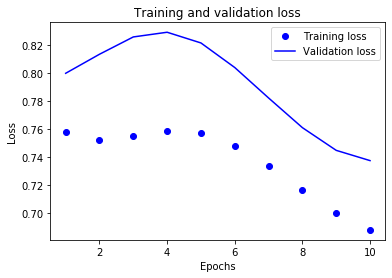

In [45]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

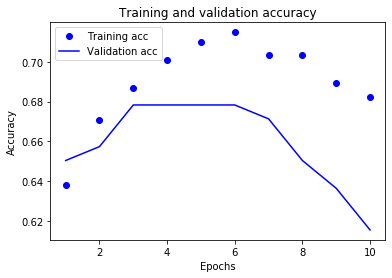

In [46]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In this plot, the dots represent the training loss and accuracy, and the solid lines are the validation loss and accuracy.

Notice the training loss *decreases* with each epoch and the training accuracy *increases* with each epoch. This is expected when using a gradient descent optimization—it should minimize the desired quantity on every iteration.

This isn't the case for the validation loss and accuracy—they seem to peak after about twenty epochs. This is an example of overfitting: the model performs better on the training data than it does on data it has never seen before. After this point, the model over-optimizes and learns representations *specific* to the training data that do not *generalize* to test data.

For this particular case, we could prevent overfitting by simply stopping the training after twenty or so epochs. Later, you'll see how to do this automatically with a callback.